# 2. Tensorflow Prophet Testing

## I - Setup

In [1]:
# Import of librairies
import tensorflow as tf
import mysql.connector as mariadb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler

In [2]:
class sql_query:
    def __init__(self, credentials_path):
        self.db_credentials = pd.read_csv(credentials_path, index_col="Field")
      
    
    def __call__(self, query):
        
        mariadb_connection = mariadb.connect(
            user=self.db_credentials.loc["user"][0],
            password=self.db_credentials.loc["password"][0],
            host=self.db_credentials.loc["host"][0],
            port=3306,
            db = "db_velib")
        
        self.cursor = mariadb_connection.cursor()
    
        cursor = self.cursor
        cursor.execute(query)
        field_names = [i[0] for i in cursor.description]
        df = pd.DataFrame(cursor, columns=field_names)
        return df

## II. Adaptation pipeline

In [3]:
# Taking data from  station 9034 - Madeleine

request = sql_query("../../aws_mariadb_crendentials.csv")

query = """
SELECT DISTINCT * FROM velib_realtime
WHERE station_id = 9034
AND date_of_update > DATE("2020-05-05")
ORDER BY date_of_update ASC
"""

df_full = request(query)

In [4]:
df_full.head()

,station_id,operational_station,nb_free_docks,nb_total_free_bikes,nb_free_mechanical_bikes,nb_free_electrical_bikes,payment_totem,bike_return_possible,data_actualisation,date_of_update
0,9034,OUI,20,2,1,1,OUI,OUI,2020-05-04 23:26:49,2020-05-05 00:01:00
1,9034,OUI,20,2,1,1,OUI,OUI,2020-05-04 23:26:49,2020-05-05 00:02:00
2,9034,OUI,20,2,1,1,OUI,OUI,2020-05-04 23:26:49,2020-05-05 00:03:00
3,9034,OUI,20,2,1,1,OUI,OUI,2020-05-04 23:26:49,2020-05-05 00:04:00
4,9034,OUI,20,2,1,1,OUI,OUI,2020-05-04 23:26:49,2020-05-05 00:05:00


In [5]:
# Creating smaller dataset

In [6]:
df = df_full['nb_free_docks']
df.index = df_full['date_of_update']
df.head()

date_of_update
2020-05-05 00:01:00    20
2020-05-05 00:02:00    20
2020-05-05 00:03:00    20
2020-05-05 00:04:00    20
2020-05-05 00:05:00    20
Name: nb_free_docks, dtype: int64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f5b35025350>],
      dtype=object)

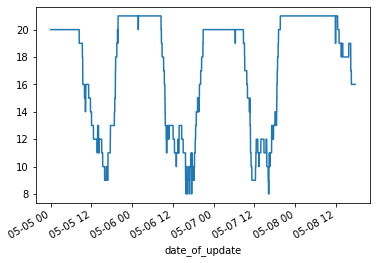

In [7]:
# Graphic visualisation
df.plot(subplots=True)

# A Pré-processing

In [8]:
# Transforming the input data in the proper format 

def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [9]:
# Setting the train_split value for later use (around 70%)
TRAIN_SPLIT = 3000
tf.random.set_seed(13)
past_history = 180
future_target = 180
STEP = 1
BATCH_SIZE = 32
BUFFER_SIZE = 10000

We intend to use the last 60 recorded temperature observations to predict the temperature at 60 next step

In [10]:
# StandardScaler transformation of the dataset

std = StandardScaler()
std.fit(df[:TRAIN_SPLIT].values.reshape(-1, 1))
df = std.transform(df.values.reshape(-1, 1))

# Creating proper format data

x_train, y_train = multivariate_data(df, df[1:], 0, TRAIN_SPLIT,
                                           past_history,
                                           future_target, STEP)
x_val, y_val = multivariate_data(df, df[1:], TRAIN_SPLIT, None,
                                       past_history,
                                       future_target, STEP)

# Creating format for NN intput

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], 1)

# Creating batches for tensorflow use

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_data = val_data.batch(BATCH_SIZE).repeat()

# Modeling

In [11]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train.shape[-2:]),
    tf.keras.layers.Dense(future_target)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [12]:
simple_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 8)                 320       
_________________________________________________________________
dense (Dense)                (None, 180)               1620      
Total params: 1,940
Trainable params: 1,940
Non-trainable params: 0
_________________________________________________________________


In [13]:
for x, y in train_data.take(1):
    print ('Shape of input train data')
    print (x_train.shape)
    print ('\n Shape of test train data')
    print (y_train.shape)   
    print ('\n Shape of test train data')
    print (simple_lstm_model.predict(x).shape)

Shape of input train data
(2820, 180, 1)

 Shape of test train data
(2820, 180, 1)

 Shape of test train data
(32, 180)


In [14]:
EPOCHS = 10
EVALUATION_INTERVAL = 200

simple_lstm_model_history = simple_lstm_model.fit(train_data, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data,
                                            validation_steps=200)


Train for 200 steps, validate for 200 steps
Epoch 1/10
200/200 [==============================] - 4s 19ms/step - loss: 0.6729 - val_loss: 0.4250
Epoch 2/10
200/200 [==============================] - 3s 13ms/step - loss: 0.3768 - val_loss: 0.3049
Epoch 3/10
200/200 [==============================] - 3s 13ms/step - loss: 0.3453 - val_loss: 0.3010
Epoch 4/10
200/200 [==============================] - 3s 13ms/step - loss: 0.3225 - val_loss: 0.3033
Epoch 5/10
200/200 [==============================] - 3s 13ms/step - loss: 0.3126 - val_loss: 0.3037
Epoch 6/10
200/200 [==============================] - 3s 13ms/step - loss: 0.3056 - val_loss: 0.3027
Epoch 7/10
200/200 [==============================] - 3s 14ms/step - loss: 0.3067 - val_loss: 0.3035
Epoch 8/10
200/200 [==============================] - 3s 14ms/step - loss: 0.2900 - val_loss: 0.2926
Epoch 9/10
200/200 [==============================] - 3s 13ms/step - loss: 0.2881 - val_loss: 0.2833
Epoch 10/10
200/200 [==========================

# C - Visualization

In [15]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

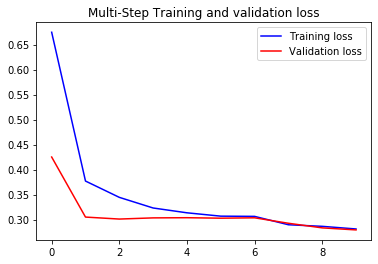

In [16]:
plot_train_history(simple_lstm_model_history, 'Multi-Step Training and validation loss')

In [17]:
def create_time_steps(length):
  return list(range(-length, 0))

In [26]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(15, 5))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)
  plt.plot(num_in, std.inverse_transform(np.array(history)), label='History')
  plt.plot(np.arange(num_out)/STEP, std.inverse_transform(np.array(true_future)), 
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.round(std.inverse_transform(np.array(prediction))), 
             label='Predicted Future')
  plt.legend(loc='upper left')

    
  x1, y1 = [0,0], [0, 25]
  ax = plt.plot(x1, y1, linestyle="dashdot", color="black")
  plt.show()

## III . Results

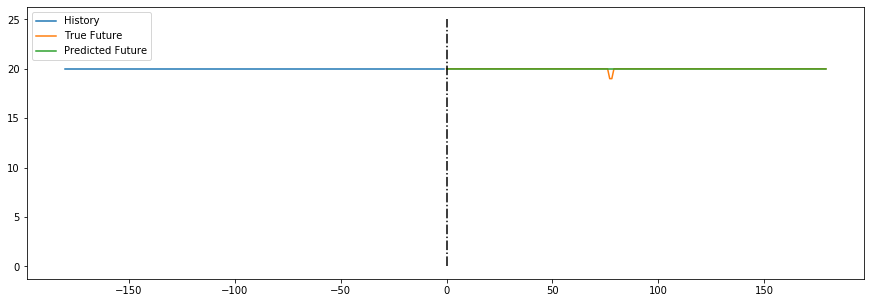

In [27]:
for x, y in val_data.take(1):
    multi_step_plot(x[0], y[0], simple_lstm_model.predict(x)[0])

## IV. Test with Last Availiable Data

In [20]:
def last_availiable_data(dataset, past_size, future_size, model):
    last_data = dataset[-past_size-future_size:]
    past = last_data[:past_size]
    future = last_data[-future_size:]
    past = past.reshape(1, past_size, 1)
    future = future.reshape(1, future_size, 1)
    prediction = model.predict(past)
    return (past.reshape(past_size), future.reshape(future_size), prediction.reshape(future_size))

In [21]:
history, true_future, prediction = last_availiable_data(df, past_history, future_target, simple_lstm_model)

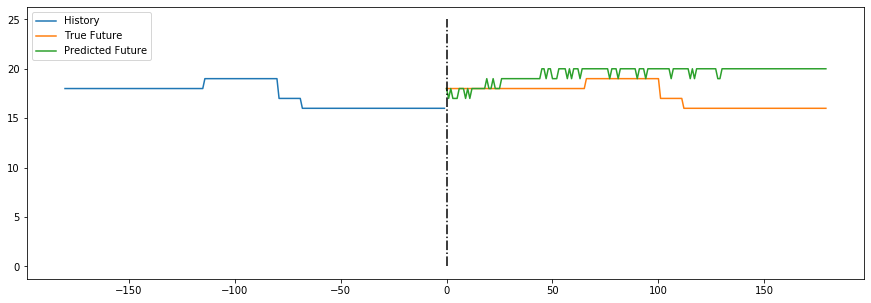

In [28]:
multi_step_plot(history, true_future, prediction)

## IV. Prediction future data

In [23]:
def future_data(dataset, past_size, future_size, model):
    last_data = dataset[-past_size:]
    past = last_data[:past_size]
    past = past.reshape(1, past_size, 1)
    prediction = model.predict(past)
    # Reshaping of output
    past = past.reshape(past_size)
    future = np.zeros(future_size)+past[-1:]
    prediction = prediction.reshape(future_size)
    
    return (past, future, prediction)

In [24]:
history, future, prediction = future_data(df, past_history, future_target, simple_lstm_model)

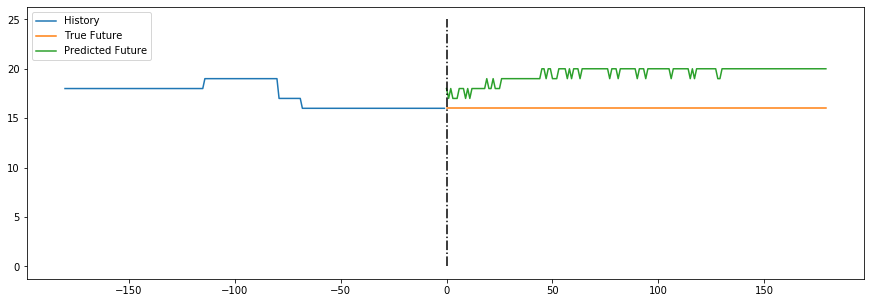

In [29]:
multi_step_plot(history, future, prediction)